# Feasibility Studies for Smartwatch

We're interested in a few things, but I'll probably hash them out properly later

### Response Rate
How often a participant entered a "No response", per day of the study

In [1]:
"""
Find "No response" rate per user per day of the study

"""
import pandas as pd
import numpy as np
from typing import Union

from ema import clean

meal_info = clean.cleaned_smartwatch(remove_catchups=True)


def fraction(positive: pd.Series, negative: pd.Series) -> float:
    """
    Given two series of positive and negative responses, find the fraction of positive responses

    """
    return len(positive) / (len(positive) + len(negative))


def fraction_err(positive: pd.Series, negative: pd.Series) -> float:
    """
    Given two series of positive and negative responses, find error on the fraction of positive responses

    """
    # I think this is right...
    return fraction(positive, negative) * np.sqrt(1 / (len(positive) + len(negative)))


def fraction_per_day(meal_df: pd.DataFrame, label: Union[str, list]) -> tuple:
    """
    Get the fraction per day and its error for a specified type of meal_type

    """
    if isinstance(label, str):
        label = [label]

    all_labels = ["Meal", "Snack", "Drink", "No food/drink", "No response"]
    for l in label:
        assert l in all_labels, l

    # Iterate over days, slicing per day and finding the fraction of responses
    fractions, errors = [], []

    for day in range(1, 8):
        # Find how many positive and negative responses on each day
        mask = (meal_df["delta"] > pd.Timedelta(days=day)) & (
            meal_df["delta"] < pd.Timedelta(days=day + 1)
        )
        meals_on_this_day = meal_df[mask]
        positive = meals_on_this_day[meals_on_this_day["meal_type"].isin(label)]
        negative = meals_on_this_day[
            meals_on_this_day["meal_type"].isin(
                [l for l in all_labels if l not in label]
            )
        ]

        # Find the fraction of positive responses
        fractions.append(fraction(positive, negative))

        # Find its uncertainty by bootstrapping

        # Find the standard deviation of the fractions
        # This is the error
        errors.append(fraction_err(positive, negative))

    return np.array(fractions), np.array(errors)

/home/mh19137/seaco_malaysia/ema/util.py:47: UserWarning: Not all dates are in 2022: set(dates.year.unique())={2021, 2022} 
  warnings.warn(f"Not all dates are in 2022: {set(dates.year.unique())=} ")
/home/mh19137/seaco_malaysia/ema/util.py:49: UserWarning: Dates are not a datetime series: type(dates)=<class 'pandas.core.series.Series'>
  warnings.warn(f"Dates are not a datetime series: {type(dates)=}")
/home/mh19137/seaco_malaysia/ema/util.py:49: UserWarning: Dates are not a datetime series: type(dates)=<class 'pandas.core.series.Series'>
  warnings.warn(f"Dates are not a datetime series: {type(dates)=}")


/tmp/ipykernel_37727/939264812.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels([f"Day {i}" for i in range(8)])


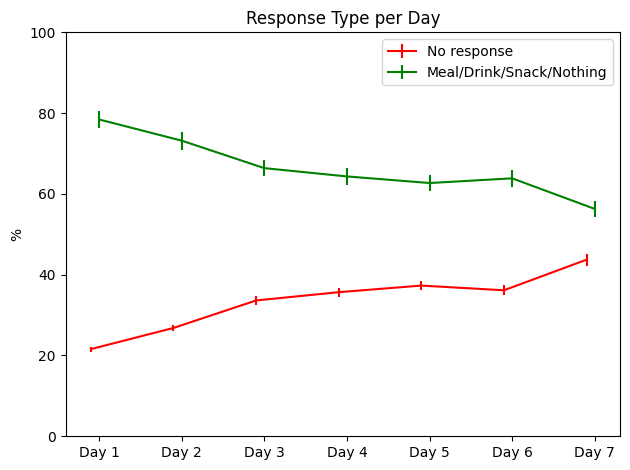

In [2]:
"""
Plot them

"""
import matplotlib.pyplot as plt


def plot(
    axis: plt.Axes, fractions: np.ndarray, errs: np.ndarray, x_ticks, **plot_kw
) -> None:
    """
    Plot the specified fractions and errors on the provided axis

    """
    axis.errorbar(
        x_ticks,
        100 * fractions,
        yerr=100 * errs,
        fmt="-",
        **plot_kw,
    )


fig, axis = plt.subplots()

plot(
    axis,
    *fraction_per_day(meal_info, "No response"),
    np.arange(1, 8) - 0.1,
    label="No response",
    color="r",
)
plot(
    axis,
    *fraction_per_day(meal_info, ["Meal", "Drink", "Snack", "No food/drink"]),
    np.arange(1, 8),
    label="Meal/Drink/Snack/Nothing",
    color="g",
)

axis.set_xticklabels([f"Day {i}" for i in range(8)])

axis.set_ylim(0, 100)
axis.set_title("Response Type per Day")
axis.set_ylabel("%")
axis.legend()

fig.tight_layout()
fig.savefig("img/response_types.png")

It looks like the response rate goes down during the study, but we want to formally check this.

Let's do this with a multilevel model; we want to check whether a positive/negative is are predicted by the day of the study for each participant.
To do this we'll make a dataframe holding the day of the study, the participant ID and whether each entry was a no-response

In [3]:
meal_info = clean.cleaned_smartwatch(remove_catchups=True)

# Create a dataframe holding the right information
model_df = pd.DataFrame()

# Participant ID and entry day
model_df["p_id"] = meal_info["p_id"]
model_df["day"] = meal_info["delta"].dt.days

# Whether each entry was a response or not
model_df["entry"] = (
    meal_info["meal_type"].isin({"Meal", "Drink", "Snack", "No food/drink"}).astype(int)
)

/home/mh19137/seaco_malaysia/ema/util.py:47: UserWarning: Not all dates are in 2022: set(dates.year.unique())={2021, 2022} 
  warnings.warn(f"Not all dates are in 2022: {set(dates.year.unique())=} ")
/home/mh19137/seaco_malaysia/ema/util.py:49: UserWarning: Dates are not a datetime series: type(dates)=<class 'pandas.core.series.Series'>
  warnings.warn(f"Dates are not a datetime series: {type(dates)=}")
/home/mh19137/seaco_malaysia/ema/util.py:49: UserWarning: Dates are not a datetime series: type(dates)=<class 'pandas.core.series.Series'>
  warnings.warn(f"Dates are not a datetime series: {type(dates)=}")


In [4]:
import pymc as pm

meal_info = clean.cleaned_smartwatch(remove_catchups=True)

# We only want the first 7 days
keep = meal_info["delta"] <= pd.Timedelta(days=8)
meal_info = meal_info[keep]
print(len(keep), keep.sum())

# Create a dataframe holding the right information
model_df = pd.DataFrame()

# Participant ID and entry day
model_df["p_id"] = meal_info["p_id"]
model_df["day"] = meal_info["delta"].dt.days

# Whether each entry was a response or not
model_df["entry"] = (
    meal_info["meal_type"].isin({"Meal", "Drink", "Snack", "No food/drink"}).astype(int)
)


def linear_model(model_df: pd.DataFrame):
    # Define the model
    with pm.Model() as model:
        # Priors
        intercept = pm.Normal("intercept", mu=0, sigma=10)
        day_coef = pm.Normal("day_coef", mu=0, sigma=10)
        p_id_sd = pm.HalfNormal("p_id_sd", sigma=10)
        p_id = pm.Normal("p_id", mu=0, sigma=p_id_sd, shape=model_df["p_id"].nunique())

        model_df["p_id"] = model_df["p_id"].astype("category").cat.codes

        # Expected value of outcome (using the logit link function)
        logit_p = intercept + day_coef * model_df["day"] + p_id[model_df["p_id"]]

        # Likelihood
        entry = pm.Binomial(
            "entry", n=1, p=pm.math.invlogit(logit_p), observed=model_df["entry"]
        )

        # Fit the model
        trace = pm.sample(draws=2000, tune=1000, target_accept=0.95)

    return model, trace


# Print the summary
model, trace = linear_model(model_df)
pm.summary(trace)

/home/mh19137/seaco_malaysia/ema/util.py:47: UserWarning: Not all dates are in 2022: set(dates.year.unique())={2021, 2022} 
  warnings.warn(f"Not all dates are in 2022: {set(dates.year.unique())=} ")
/home/mh19137/seaco_malaysia/ema/util.py:49: UserWarning: Dates are not a datetime series: type(dates)=<class 'pandas.core.series.Series'>
  warnings.warn(f"Dates are not a datetime series: {type(dates)=}")
/home/mh19137/seaco_malaysia/ema/util.py:49: UserWarning: Dates are not a datetime series: type(dates)=<class 'pandas.core.series.Series'>
  warnings.warn(f"Dates are not a datetime series: {type(dates)=}")


7719 7177


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, day_coef, p_id_sd, p_id]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 53 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,1.551,0.137,1.277,1.798,0.004,0.003,1065.0,1984.0,1.0
day_coef,-0.225,0.015,-0.253,-0.197,0.000,0.000,12260.0,6170.0,1.0
p_id[0],-0.270,0.253,-0.740,0.208,0.005,0.003,2991.0,4844.0,1.0
p_id[1],-1.261,0.242,-1.730,-0.818,0.004,0.003,3094.0,4549.0,1.0
p_id[2],0.513,0.268,0.013,1.026,0.005,0.003,3571.0,4252.0,1.0
...,...,...,...,...,...,...,...,...,...
p_id[79],-0.030,0.260,-0.514,0.456,0.004,0.003,3458.0,4413.0,1.0
p_id[80],-0.017,0.243,-0.473,0.441,0.004,0.003,3015.0,4165.0,1.0
p_id[81],-1.154,0.308,-1.701,-0.548,0.005,0.003,4502.0,4128.0,1.0
p_id[82],0.041,0.245,-0.405,0.516,0.004,0.003,2969.0,4242.0,1.0


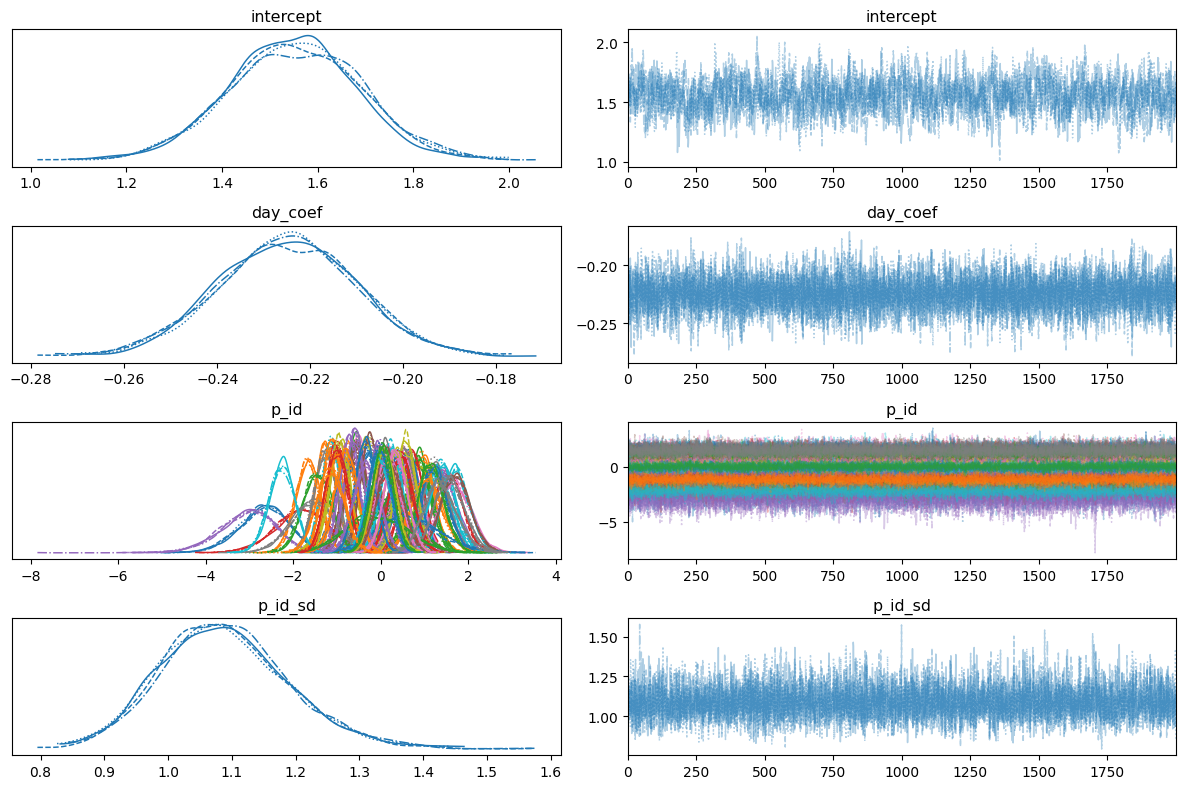

In [5]:
axes = pm.plot_trace(trace)
fig = axes.ravel()[0].get_figure()
fig.tight_layout()
fig.savefig("img/model_summary.png")

In [6]:
model.to_graphviz().render(filename=f"model1", format="png")

'model1.png'

mean            -0.225
sd               0.015
hdi_5%          -0.249
hdi_95%         -0.200
mcse_mean        0.000
mcse_sd          0.000
ess_bulk     12260.000
ess_tail      6170.000
r_hat            1.000
Name: day_coef, dtype: float64


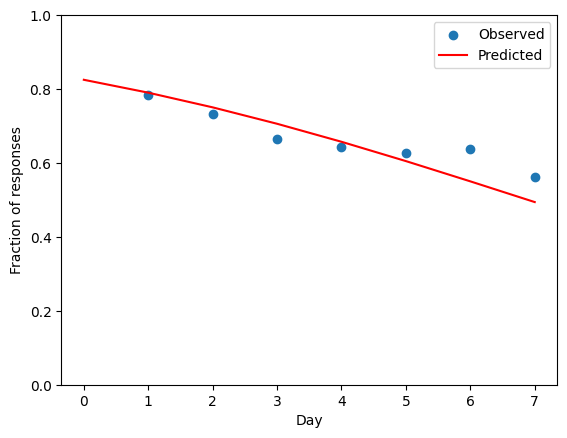

In [7]:
import matplotlib.pyplot as plt
import numpy as np


def lineplot(trace, path):
    print(pm.summary(trace, hdi_prob=0.90).loc["day_coef"])  # 95% HPD

    fig, axis = plt.subplots()

    # Group data by day and calculate mean of entry
    grouped = model_df.groupby("day")["entry"].mean()

    # Plot percentage of entries that equal 1
    axis.scatter(grouped.index, grouped, label="Observed")

    # Calculate predicted probabilities
    days = np.arange(0, 8)
    pred_probs = pm.invlogit(
        trace.posterior["intercept"].mean().item()
        + trace.posterior["day_coef"].mean().item() * days
    ).eval()

    # Plot predicted probabilities
    axis.plot(days, pred_probs, color="red", label="Predicted")

    axis.set_xlabel("Day")
    axis.set_ylabel("Fraction of responses")

    axis.set_ylim(0, 1)

    axis.legend()

    fig.savefig(path)


lineplot(trace, "img/linear_model.png")

In [8]:
""" Repeat, removing Ramadan """
import pymc as pm

meal_info = clean.cleaned_smartwatch(remove_catchups=True)

meal_info = meal_info[~meal_info["any_in_ramadan"]]

keep = meal_info["delta"] <= pd.Timedelta(days=8)
meal_info = meal_info[keep]
print(len(keep), keep.sum())

# Create a dataframe holding the right information
model_df = pd.DataFrame()

# Participant ID and entry day
model_df["p_id"] = meal_info["p_id"]
model_df["day"] = meal_info["delta"].dt.days

# Whether each entry was a response or not
model_df["entry"] = (
    meal_info["meal_type"].isin({"Meal", "Drink", "Snack", "No food/drink"}).astype(int)
)

# Print the summary
model, trace = linear_model(model_df)

/home/mh19137/seaco_malaysia/ema/util.py:47: UserWarning: Not all dates are in 2022: set(dates.year.unique())={2021, 2022} 
  warnings.warn(f"Not all dates are in 2022: {set(dates.year.unique())=} ")
/home/mh19137/seaco_malaysia/ema/util.py:49: UserWarning: Dates are not a datetime series: type(dates)=<class 'pandas.core.series.Series'>
  warnings.warn(f"Dates are not a datetime series: {type(dates)=}")
/home/mh19137/seaco_malaysia/ema/util.py:49: UserWarning: Dates are not a datetime series: type(dates)=<class 'pandas.core.series.Series'>
  warnings.warn(f"Dates are not a datetime series: {type(dates)=}")


6371 5895


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, day_coef, p_id_sd, p_id]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 46 seconds.


mean            -0.219
sd               0.016
hdi_5%          -0.246
hdi_95%         -0.192
mcse_mean        0.000
mcse_sd          0.000
ess_bulk     12946.000
ess_tail      6202.000
r_hat            1.000
Name: day_coef, dtype: float64


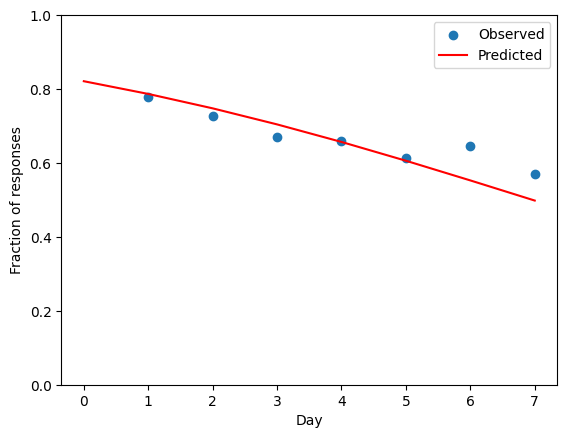

In [9]:
pm.summary(trace)

lineplot(trace, "img/linear_model_no_ramadan.png")